In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
import itertools

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


2025-08-07 11:43:45.968329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [3]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [4]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

In [ ]:
transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymph1_transferred.txt', dtype=str)
ko_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO4_transferred.txt', dtype=str)
ko2_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO2_transferred.txt', dtype=str)

# transferred = adata_control.obs.index.tolist()
# ko_transferred = adata_ko.obs.index.tolist()
# ko2_transferred = adata_ko2.obs.index.tolist()

len(transferred), len(ko_transferred), len(ko2_transferred)

(488, 632, 517)

In [6]:
# Remove the Tregs from the transferred list since the correct proportion is low

transferred = [cell for cell in transferred if adata_control.obs.loc[cell, 'cell_type'] != 'Treg']
ko_transferred = [cell for cell in ko_transferred if adata_ko.obs.loc[cell, 'cell_type'] != 'Treg']
ko2_transferred = [cell for cell in ko2_transferred if adata_ko2.obs.loc[cell, 'cell_type'] != 'Treg']
len(transferred), len(ko_transferred), len(ko2_transferred)


(176, 172, 198)

In [7]:
adata_control.X = adata_control.layers['normalized_count']
adata_ko.X = adata_ko.layers['normalized_count']
adata_ko2.X = adata_ko2.layers['normalized_count']

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

In [8]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)


In [9]:
adata_control.obs['banksy_cluster'] = lymph1_banksy_df['banksy_cluster']
adata_ko.obs['banksy_cluster'] = lymphko4_banksy_df['banksy_cluster']
adata_ko2.obs['banksy_cluster'] = lymphko2_banksy_df['banksy_cluster']

adata_control.obs['1DER_cell_type'] = np.where(adata_control.obs.index.isin(transferred), adata_control.obs['cell_type'], 'NA')
adata_ko.obs['1DER_cell_type'] = np.where(adata_ko.obs.index.isin(ko_transferred), adata_ko.obs['cell_type'], 'NA')
adata_ko2.obs['1DER_cell_type'] = np.where(adata_ko2.obs.index.isin(ko2_transferred), adata_ko2.obs['cell_type'], 'NA')

adata_control.obs['1DER_cell_type'] = '1DER ' + adata_control.obs['1DER_cell_type'].astype(str)
adata_ko.obs['1DER_cell_type'] = '1DER ' + adata_ko.obs['1DER_cell_type'].astype(str)
adata_ko2.obs['1DER_cell_type'] = '1DER ' + adata_ko2.obs['1DER_cell_type'].astype(str)


In [10]:
# import commot as ct
# from spaceoracle.models.parallel_estimators import expand_paired_interactions


# df_ligrec = ct.pp.ligand_receptor_database(
#     database='CellChat', 
#     species='mouse', 
#     signaling_type=None
# ) 
# df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

# lr = expand_paired_interactions(df_ligrec)
# lr = lr[lr.ligand.isin(adata_control.var_names) &\
#     (lr.receptor.isin(adata_control.var_names))]

In [ ]:
# deg_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/slide_runs_ko/consistent_degs_Th2_Tfh.csv', index_col=0)
# deg_df

In [55]:
# import os 

# target_genes = ["Itgal", "Ccr4", "Il2ra", "Gata3"]
# betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

# data = {}
# for gene in target_genes:
#     dfs = []
#     for sample in ['a', 'b', 'c', 'd']:
#         fpath = os.path.join(betadir, f'mouse_lymph1{sample}_visiumHD', f'{gene}_betadata.parquet')
#         if os.path.exists(fpath):
#             dfs.append(pd.read_parquet(fpath))
#     if dfs:
#         data[gene] = pd.concat(dfs, axis=0)
# len(data.keys())

4

In [56]:
# interactions = {
#     'Th2': {
#         gene: data[gene].loc[adata_control[adata_control.obs['cell_type'] == 'Th2'].obs.index]
#         for gene in data.keys()
#     },
#     'Th2_transferred': {
#         gene: data[gene].loc[adata_control[(adata_control.obs['cell_type'] == 'Th2') & (adata_control.obs.index.isin(transferred))].obs.index]
#         for gene in data.keys()
#     },
#     'Cd4': {
#         gene: data[gene].loc[adata_control[adata_control.obs['cell_type'].isin(['Th2','Tfh'])].obs.index]
#         for gene in data.keys()
#     }
# }

In [115]:
# dfr = interactions['Th2']['Il2ra']
# # dfr = interactions['Th2']['Gata3']
# dfr.columns = [x.replace('beta_', '') for x in dfr.columns]

# ccr4_mods = ['Ccl17$Ccr4', 'Ccl22$Ccr4', 'Ccl5$Ccr4', 'Il16$Cd4', 'Il2$Il2rb', 'Il15$Il2rb']

In [116]:
# receptors = [x.split('$')[1] for x in ccr4_mods]
# ligands = [x.split('$')[0] for x in ccr4_mods]
# beta = dfr[ccr4_mods]

In [117]:
# th2_expr = adata_control[dfr.index, receptors].to_df(layer='imputed_count')
# env_expr = adata_control.uns['received_ligands'].loc[dfr.index, ligands]
# env_expr = np.where(adata_control.uns['cell_thresholds'].loc[dfr.index, ligands] > 0, env_expr, 0)

# wbetas = beta * th2_expr.values * env_expr
# wbetas.columns = [x.replace('$', '-') for x in wbetas.columns]


In [118]:
# wbetas_full = wbetas.copy()
# wbetas.drop(columns=['Ccl17-Ccr4', 'Il2-Il2rb', 'Il15-Il2rb'], inplace=True)
# normalization = wbetas.abs().values.max()
# wbetas = wbetas / normalization


In [120]:
# wbetas.loc[:, 'x'] = adata_control[wbetas.index, :].obsm['spatial'][:, 0].flatten()
# wbetas.loc[:, 'y'] = adata_control[wbetas.index, :].obsm['spatial'][:, 1].flatten()
# wbetas.loc[:, 'x'] = adata_control[wbetas.index, :].obsm['spatial'][:, 0].flatten()
# wbetas.loc[:, 'y'] = adata_control[wbetas.index, :].obsm['spatial'][:, 1].flatten()


# wbetas['banksy_zone'] = adata_control[wbetas.index, :].obs['banksy_cluster']
# wbetas.groupby('banksy_zone').mean()

,Ccl22-Ccr4,Ccl5-Ccr4,Il16-Cd4,x,y
banksy_zone,,,,,
B cell follicles,0.038337,0.046943,0.437468,2979.460498,11236.310389
T cell zone,0.105214,0.106808,0.606936,3090.207102,11073.871326
TB Border,0.055050,0.061802,0.526379,3182.178822,11461.449529


In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
# axs = axs.flatten()

# # Only use the three Ccr4 interaction columns for vmin/vmax
# ccr4_hues = ['Ccl5$Ccr4', 'Ccl22$Ccr4', 'Il16$Cd4']
# all_hue_mods = [hue.replace('$', '-') for hue in ccr4_hues]
# vmin = min(wbetas[hue_mod].min() for hue_mod in all_hue_mods)
# vmax = max(wbetas[hue_mod].max() for hue_mod in all_hue_mods)

# # Make the colorbar diverging: center at zero, blue for negative, red for positive
# abs_max = max(abs(vmin), abs(vmax))
# norm = plt.Normalize(-abs_max, abs_max)
# from matplotlib.colors import TwoSlopeNorm
# norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
# cmap = 'bwr'  # blue-white-red, blue for negative, red for positive

# # Plot background clusters
# for ax in axs:
#     sns.scatterplot(
#         x=adata_control.obsm['spatial'][:, 0],
#         y=adata_control.obsm['spatial'][:, 1],
#         hue=adata_control.obs['banksy_cluster'],
#         palette=color_dict,
#         s=20,
#         legend=False,
#         ax=ax,
#         alpha=0.03,
#     )

# for i, hue in enumerate(ccr4_hues):
#     hue_mod = hue.replace('$', '-')
#     # Only plot if the column exists in wbetas
#     if hue_mod in wbetas.columns:
#         sc = sns.scatterplot(
#             data=wbetas.sort_values(by=hue_mod, ascending=True),
#             x='x',
#             y='y',
#             hue=hue_mod,
#             palette=cmap,
#             s=20,
#             ax=axs[i],
#             legend=False,
#             hue_norm=norm
#         )
#         axs[i].set_aspect('equal')
#         axs[i].set_axis_off()
#         axs[i].set_title(hue)
#     else:
#         axs[i].set_visible(False)

# # Add a single unified colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
# cbar.set_label("Weighted beta (normalized)")

# plt.suptitle('SpaceTravLR interaction betas for Il2ra on Th2 cells')

Text(0.5, 0.98, 'SpaceTravLR interaction betas for Gata3 on Th2 cells')

### Neighborhood

In [12]:
from scipy.stats import mannwhitneyu
from matplotlib import gridspec

def plot_neighborhood_boxplots(dicts, dict_names, groups, radii=None, ct_interest='Th2', save_path=None):
    group_colors = color_dict
    group_colors['control_random'] = color_dict['control']
    group_colors['ko_random'] = color_dict['ko']
    group_colors['ko2_random'] = color_dict['ko2']
    
    if radii is None:
        # Infer radii from first dict
        radii = list(dicts[0].keys())
        # Sort if possible
        try:
            radii = sorted(radii)
        except Exception:
            pass

    fig, axes = plt.subplots(1, 3, figsize=(15, 7), dpi=300)
    axes = axes.flatten()

    # For significance annotation
    def significance_marker(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return None  # Only annotate significant

    for ax, dct, name in zip(axes, dicts, dict_names):
        # Prepare data for boxplot
        boxplot_data = []
        boxplot_positions = []
        boxplot_colors = []
        xtick_labels = []
        xtick_positions = []
        width = 0.2  # width between groups at each radius

        # For significance
        sig_annotations = []

        for i, radius in enumerate(radii):
            group_data = []
            for j, group in enumerate(groups):
                # Offset positions so groups are side-by-side at each radius
                pos = i + (j - 1) * width
                boxplot_positions.append(pos)
                data = dct[radius][group]
                boxplot_data.append(data)
                boxplot_colors.append(group_colors[group])
                group_data.append(data)
            xtick_labels.append(str(radius))
            xtick_positions.append(i)

            # Statistical tests: control vs ko, control vs ko2, ko vs ko2
            # Only if all groups have data
            if all([len(gd) > 0 for gd in group_data]):
                pairs = [(0,1), (0,2), (1,2)]
                for (idx1, idx2) in pairs:
                    data1 = group_data[idx1]
                    data2 = group_data[idx2]
                    try:
                        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
                    except ValueError:
                        pval = 1.0  # fallback if data is not valid
                    marker = significance_marker(pval)
                    if marker is not None:  # Only add if significant
                        # Determine color: blue if left group higher, red if lower
                        mean1 = np.nanmean(data1) if len(data1) > 0 else np.nan
                        mean2 = np.nanmean(data2) if len(data2) > 0 else np.nan
                        if np.isnan(mean1) or np.isnan(mean2):
                            color = 'k'
                        elif mean1 > mean2:
                            color = '#79a1f7'  # blue
                        elif mean1 < mean2:
                            color = 'lightcoral'  # red
                        else:
                            color = 'k'
                        sig_annotations.append({
                            'radius_idx': i,
                            'group1': groups[idx1],
                            'group2': groups[idx2],
                            'pos1': i + (idx1 - 1) * width,
                            'pos2': i + (idx2 - 1) * width,
                            'pval': pval,
                            'marker': marker,
                            'color': color
                        })

        # Draw boxplots
        bp = ax.boxplot(
            boxplot_data,
            positions=boxplot_positions,
            widths=width*0.9,
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='k', linewidth=2),
            boxprops=dict(linewidth=1.5),
            whiskerprops=dict(linewidth=1.2),
            capprops=dict(linewidth=1.2)
        )

        # Color boxes
        for patch, color in zip(bp['boxes'], boxplot_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)
            patch.set_edgecolor('k')
            patch.set_linewidth(1.5)

        # Whiskers and caps
        for whisker in bp['whiskers']:
            whisker.set_color('k')
            whisker.set_linewidth(1.2)
        for cap in bp['caps']:
            cap.set_color('k')
            cap.set_linewidth(1.2)

        # Set x-ticks at center of each radius group
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, fontsize=13)
        ax.set_xlabel('Radius (μm)', fontsize=15, labelpad=8)
        ax.set_title(f'{name} within', fontsize=16, pad=12)
        ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)

        # Remove top/right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add statistical significance bars (only for significant)
        y_max = np.nanmax([np.nanmax(d) if len(d) > 0 else np.nan for d in boxplot_data])
        y_min = np.nanmin([np.nanmin(d) if len(d) > 0 else np.nan for d in boxplot_data])
        y_range = y_max - y_min if not np.isnan(y_max) and not np.isnan(y_min) else 1
        y_offset = y_range * 0.05
        bar_height = y_max + y_offset if not np.isnan(y_max) else 1

        # For each radius, stack bars if multiple comparisons
        bar_stack = {}  # (radius_idx) -> current bar height

        for ann in sig_annotations:
            r = ann['radius_idx']
            pos1 = ann['pos1']
            pos2 = ann['pos2']
            marker = ann['marker']
            color = ann.get('color', 'k')
            base = bar_stack.get(r, bar_height)
            ax.plot([pos1, pos1, pos2, pos2], [base, base + y_offset, base + y_offset, base], color='k', lw=1.2, zorder=10)
            ax.text((pos1 + pos2) / 2, base + y_offset * 1.1, marker, ha='center', va='bottom', fontsize=15, fontweight='bold', color=color)
            bar_stack[r] = base + y_offset * 1.8

    axes[0].set_ylabel(f'Fraction within neighborhood', fontsize=15, labelpad=8)

    # Create a custom legend and move it off the plot (right side)
    handles = [
        plt.Line2D([0], [0], color=group_colors[g], lw=8, label=g, alpha=0.8)
        for g in groups
    ]
    legend_ax = fig.add_subplot(axes[2])
    legend_ax.axis('off')
    legend = legend_ax.legend(
        handles=handles,
        title='Group',
        fontsize=14,
        title_fontsize=15,
        loc='center left',
        frameon=False,
        borderaxespad=0.0,
        labelspacing=1.2,
        handlelength=2.5
    )
    plt.suptitle(f'{ct_interest} neighborhood compositions')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [13]:
from collections import defaultdict

def read_spf(radius):
    workdir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD'

    spf_control = pd.read_csv(f'{workdir}/spf_control_{radius}.csv', index_col=0)
    spf_ko = pd.read_csv(f'{workdir}/spf_ko_{radius}.csv', index_col=0)
    spf_ko2 = pd.read_csv(f'{workdir}/spf_ko2_{radius}.csv', index_col=0)

    spf_control.index = spf_control.index.astype(str)
    spf_ko.index = spf_ko.index.astype(str)
    spf_ko2.index = spf_ko2.index.astype(str)

    return {'control': spf_control, 'ko': spf_ko, 'ko2': spf_ko2}

def normalize_rows(df, adata):
    df = df.copy()

    # # normalize each column by total abundance in tissue
    # cell_counts = adata.obs.cell_type.value_counts()
    # cell_counts.rename(index=lambda x: x+'_within', inplace=True)
    # df = df / cell_counts

    # normalize each row to sum to 1 (percentage of ct_within)
    row_sums = df.sum(axis=1)
    df = df.div(row_sums, axis=0)

    return df 


In [14]:
# ctrl_th2 = adata_control[adata_control.obs.cell_type == 'Th2']
# ko_th2 = adata_ko[adata_ko.obs.cell_type == 'Th2']
# ko2_th2 = adata_ko2[adata_ko2.obs.cell_type == 'Th2']

ctrl_th2 = adata_control[(adata_control.obs.index.isin(transferred)) & (adata_control.obs.cell_type == 'Th2')]
ko_th2 = adata_ko[(adata_ko.obs.index.isin(ko_transferred)) & (adata_ko.obs.cell_type == 'Th2')]
ko2_th2 = adata_ko2[(adata_ko2.obs.index.isin(ko2_transferred)) & (adata_ko2.obs.cell_type == 'Th2')]

# ctrl_th2 = adata_control[adata_control.obs.index.isin(transferred)]
# ko_th2 = adata_ko[adata_ko.obs.index.isin(ko_transferred)]
# ko2_th2 = adata_ko2[adata_ko2.obs.index.isin(ko2_transferred)]

In [15]:
b_dicts = defaultdict(dict)
dc_dicts = defaultdict(dict)
cd8_dicts = defaultdict(dict)
th2_dicts = defaultdict(dict)
nk_dicts = defaultdict(dict)

radii = [30, 50, 100, 150, 200]

for radius in radii:
    spfs = read_spf(radius)

    spf_control = normalize_rows(spfs['control'], adata_control)
    spf_ko = normalize_rows(spfs['ko'], adata_ko)
    spf_ko2 = normalize_rows(spfs['ko2'], adata_ko2)

    b_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'CD8+ T_within'].dropna().values
    th2_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'Th2_within'].dropna().values
    nk_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'NK_within'].dropna().values

    b_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'CD8+ T_within'].dropna().values
    th2_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'Th2_within'].dropna().values
    nk_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'NK_within'].dropna().values

    b_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'CD8+ T_within'].dropna().values
    th2_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'Th2_within'].dropna().values
    nk_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'NK_within'].dropna().values

    b_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'B_within'].dropna().values
    dc_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    cd8_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    th2_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'Th2_within'].dropna().values
    th2_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'Th2_within'].dropna().values
    th2_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'Th2_within'].dropna().values
    nk_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'NK_within'].dropna().values
    nk_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'NK_within'].dropna().values
    nk_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'NK_within'].dropna().values


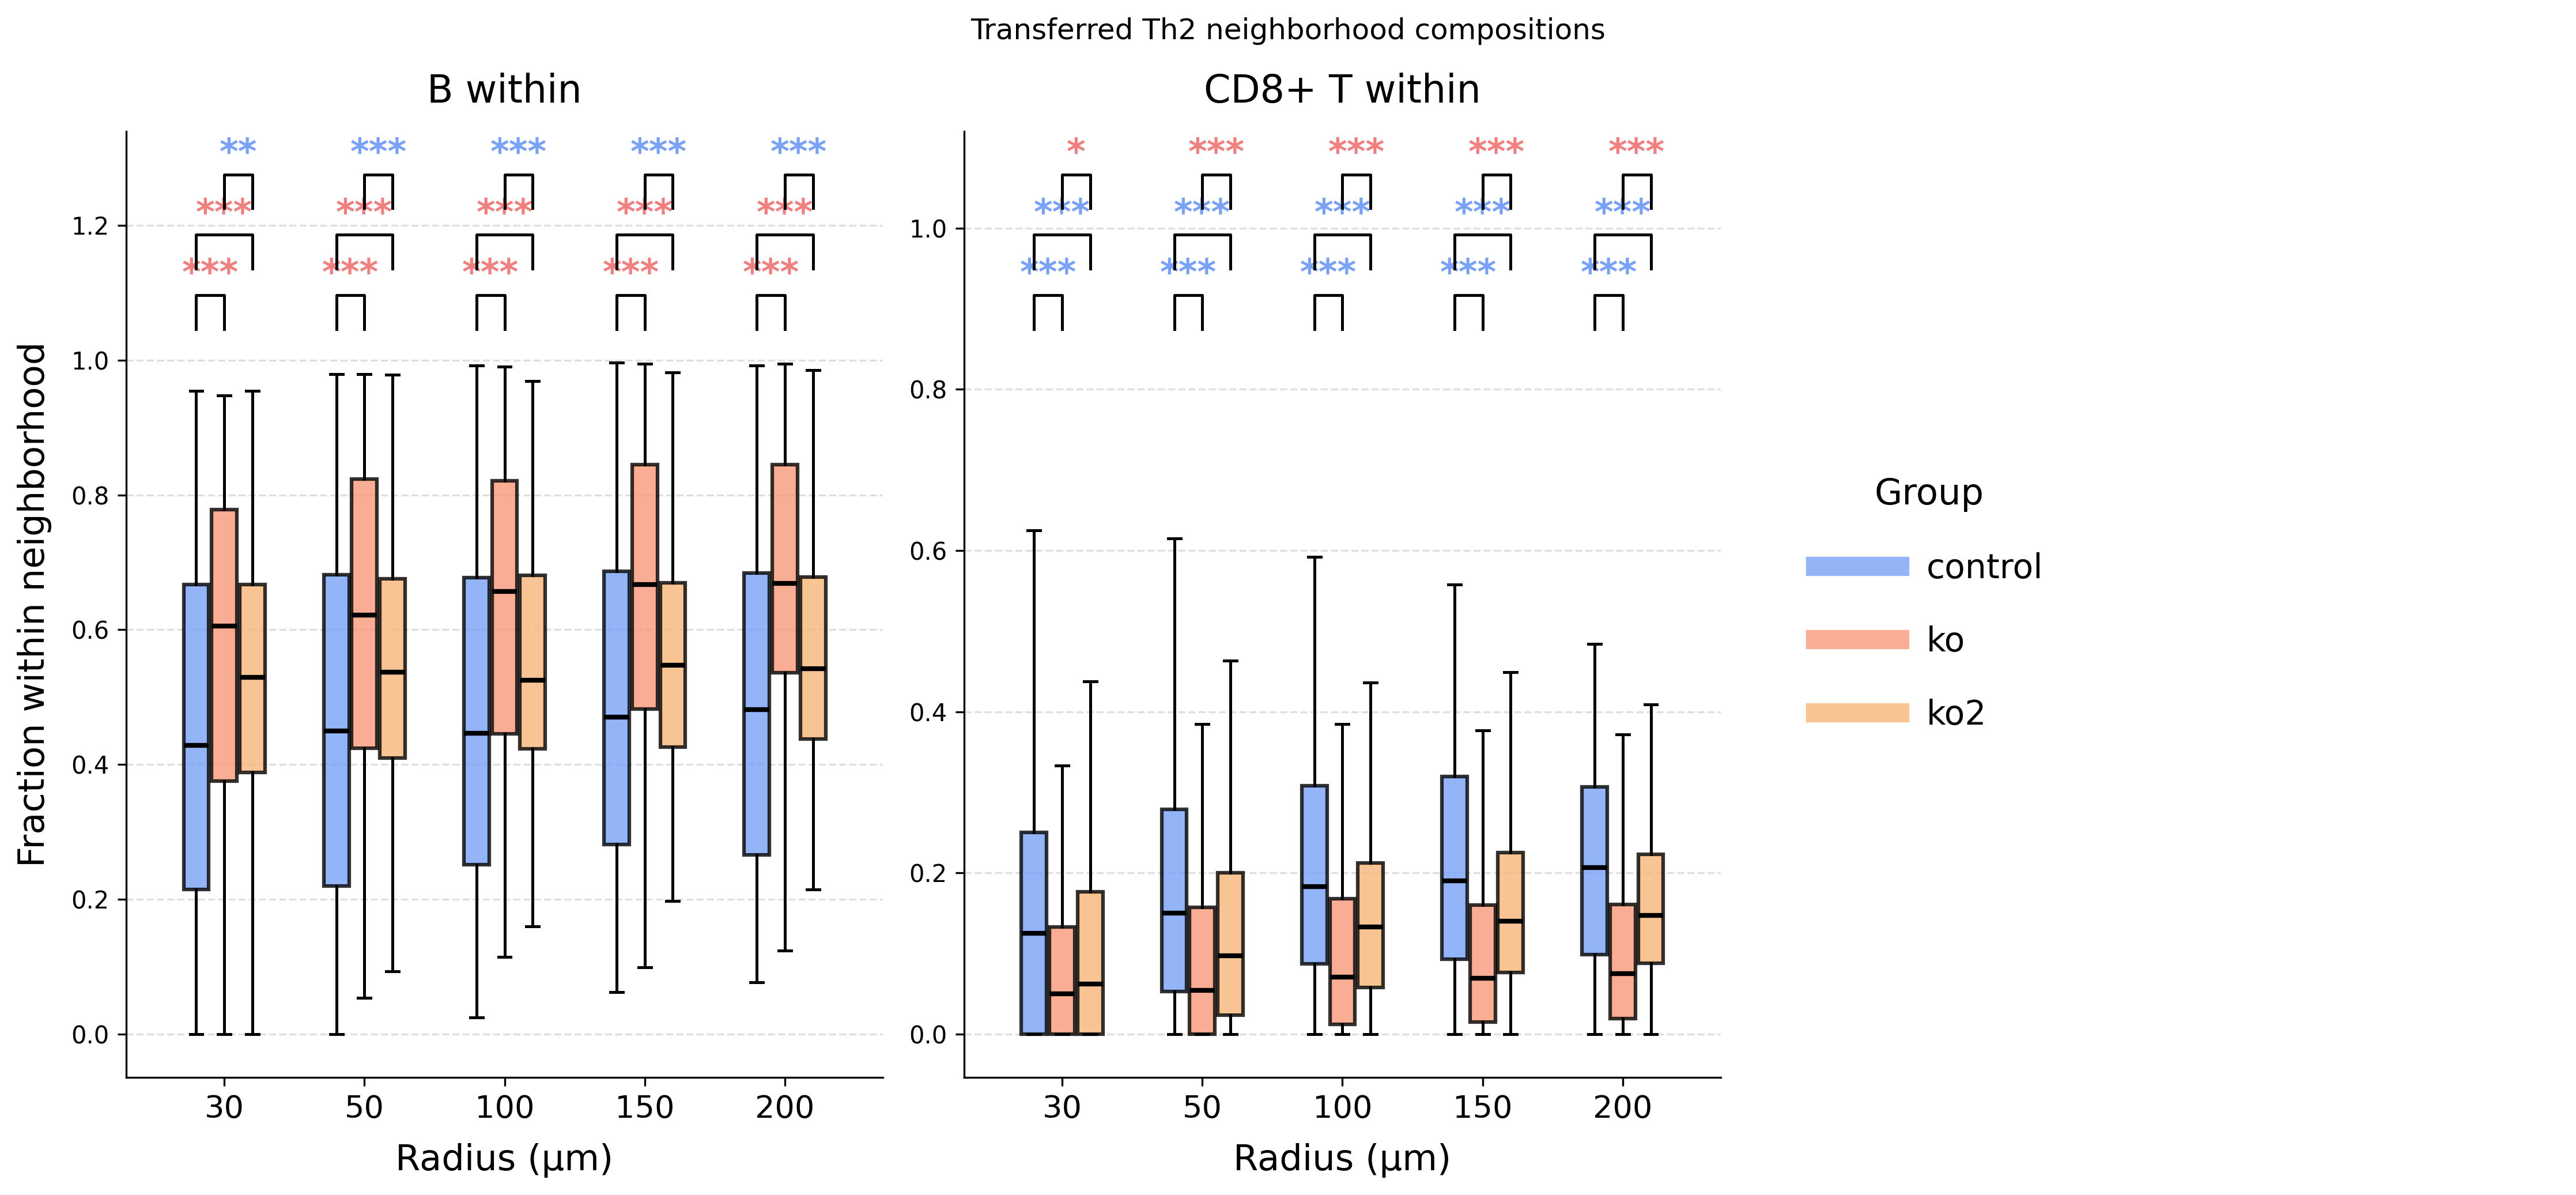

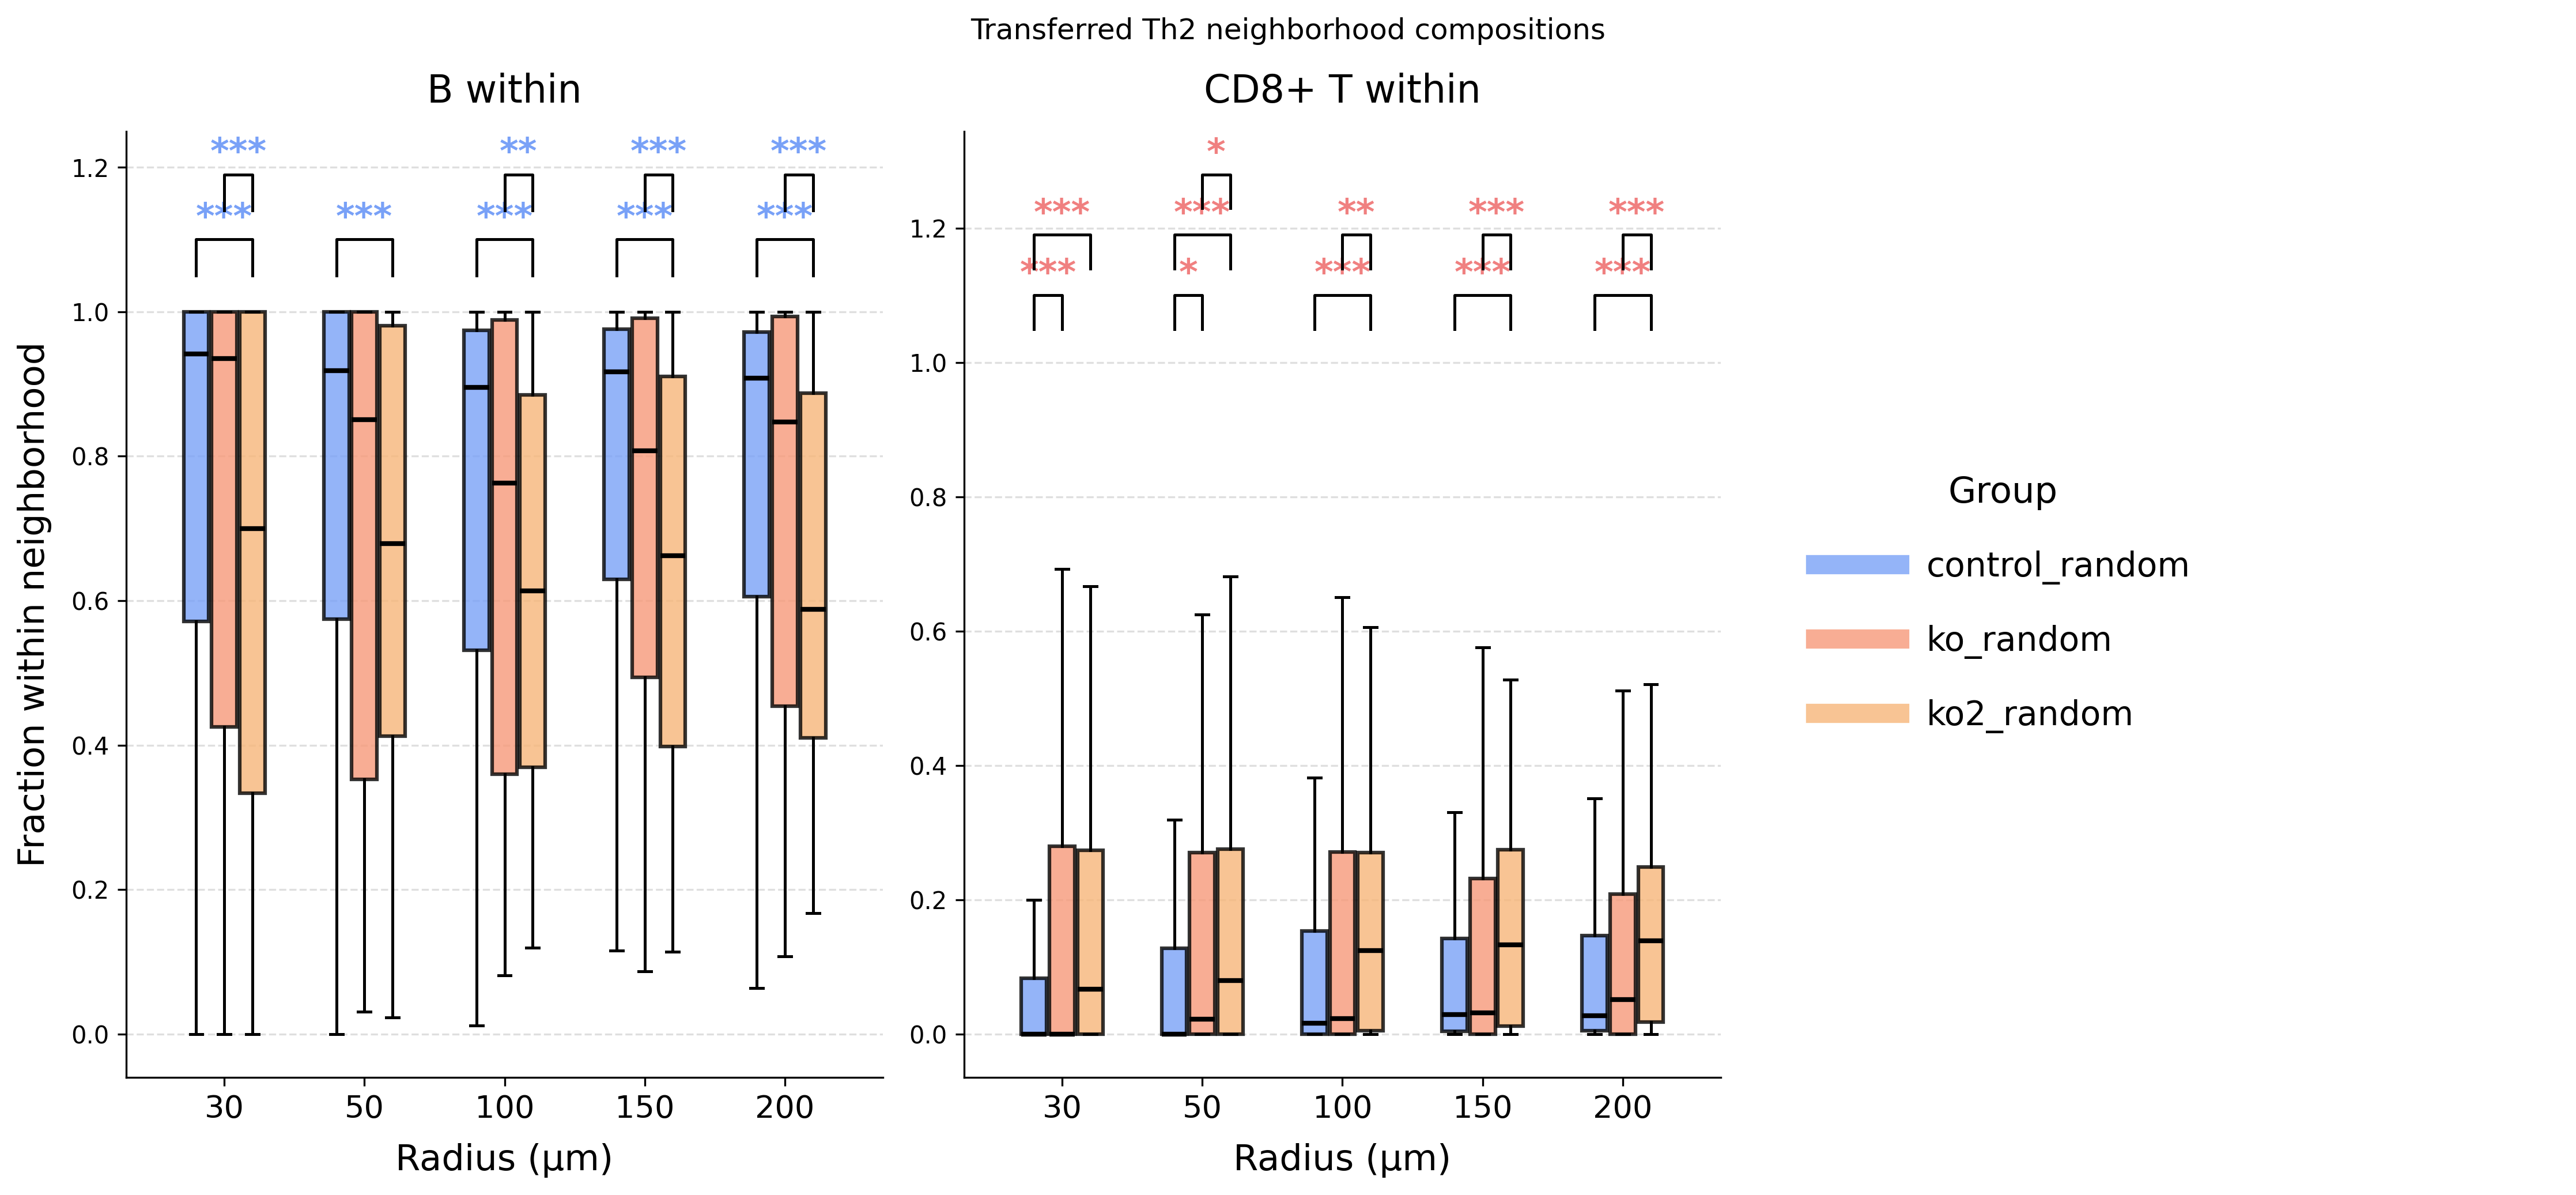

In [16]:
# All Th2 

plot_neighborhood_boxplots(
    dicts=[b_dicts, cd8_dicts],
    dict_names=['B', 'CD8+ T'],
    groups=['control', 'ko', 'ko2'],
    radii=radii,
    ct_interest='Transferred Th2'
)

plot_neighborhood_boxplots(
    dicts=[b_dicts, cd8_dicts],
    dict_names=['B', 'CD8+ T'],
    groups=['control_random', 'ko_random', 'ko2_random'],
    radii=radii,
    ct_interest='Transferred Th2'
)


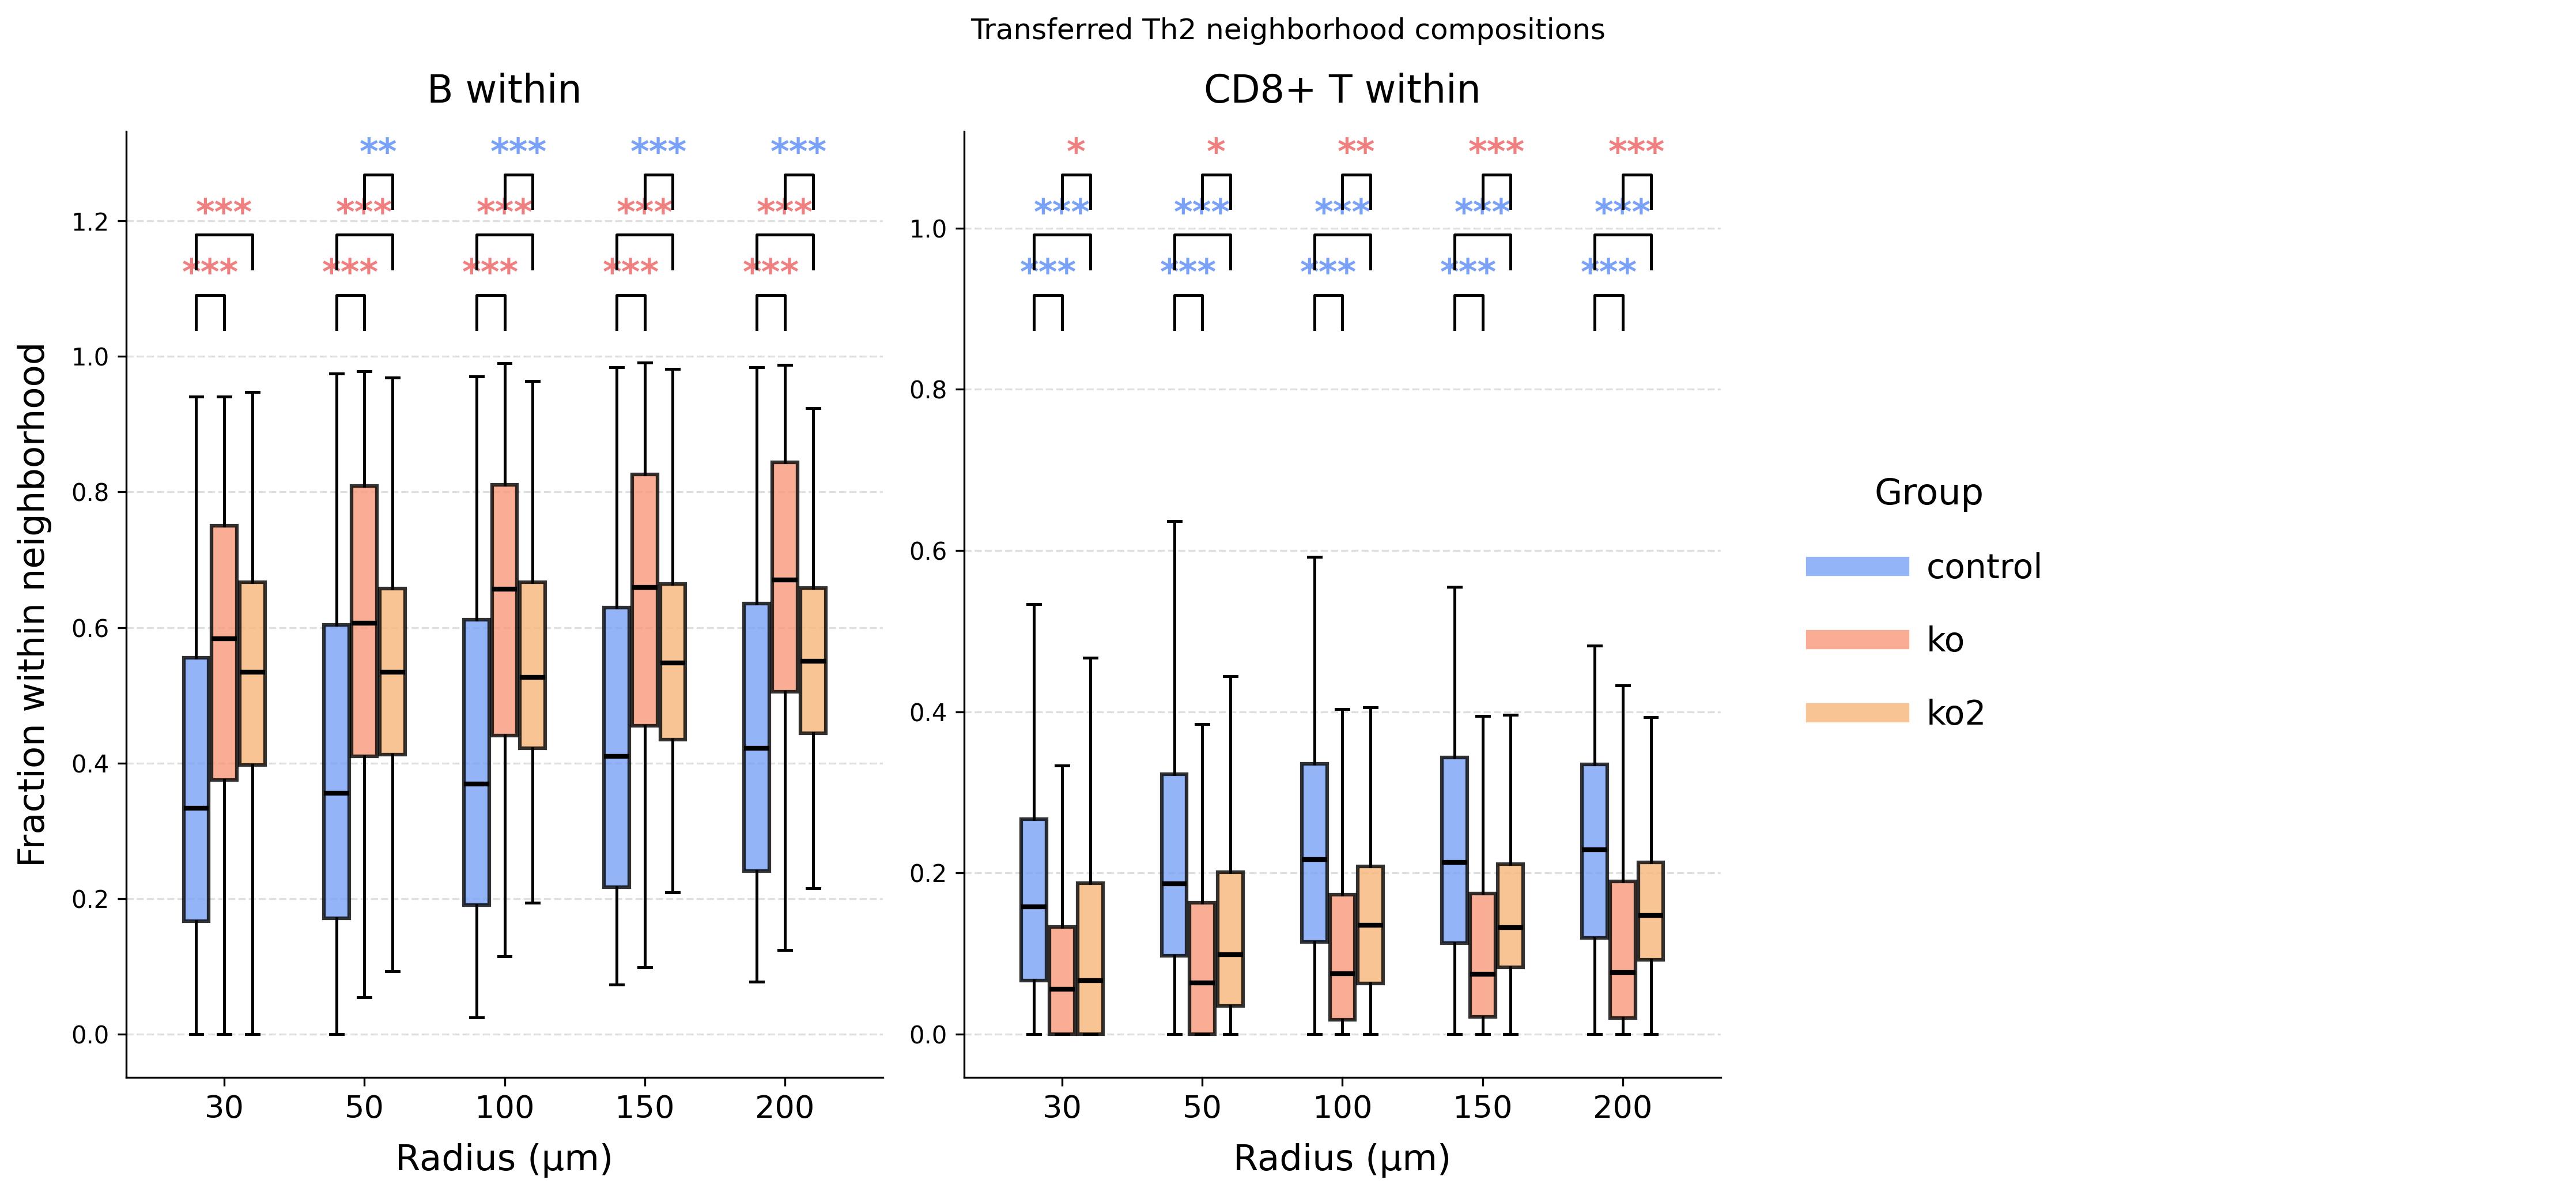

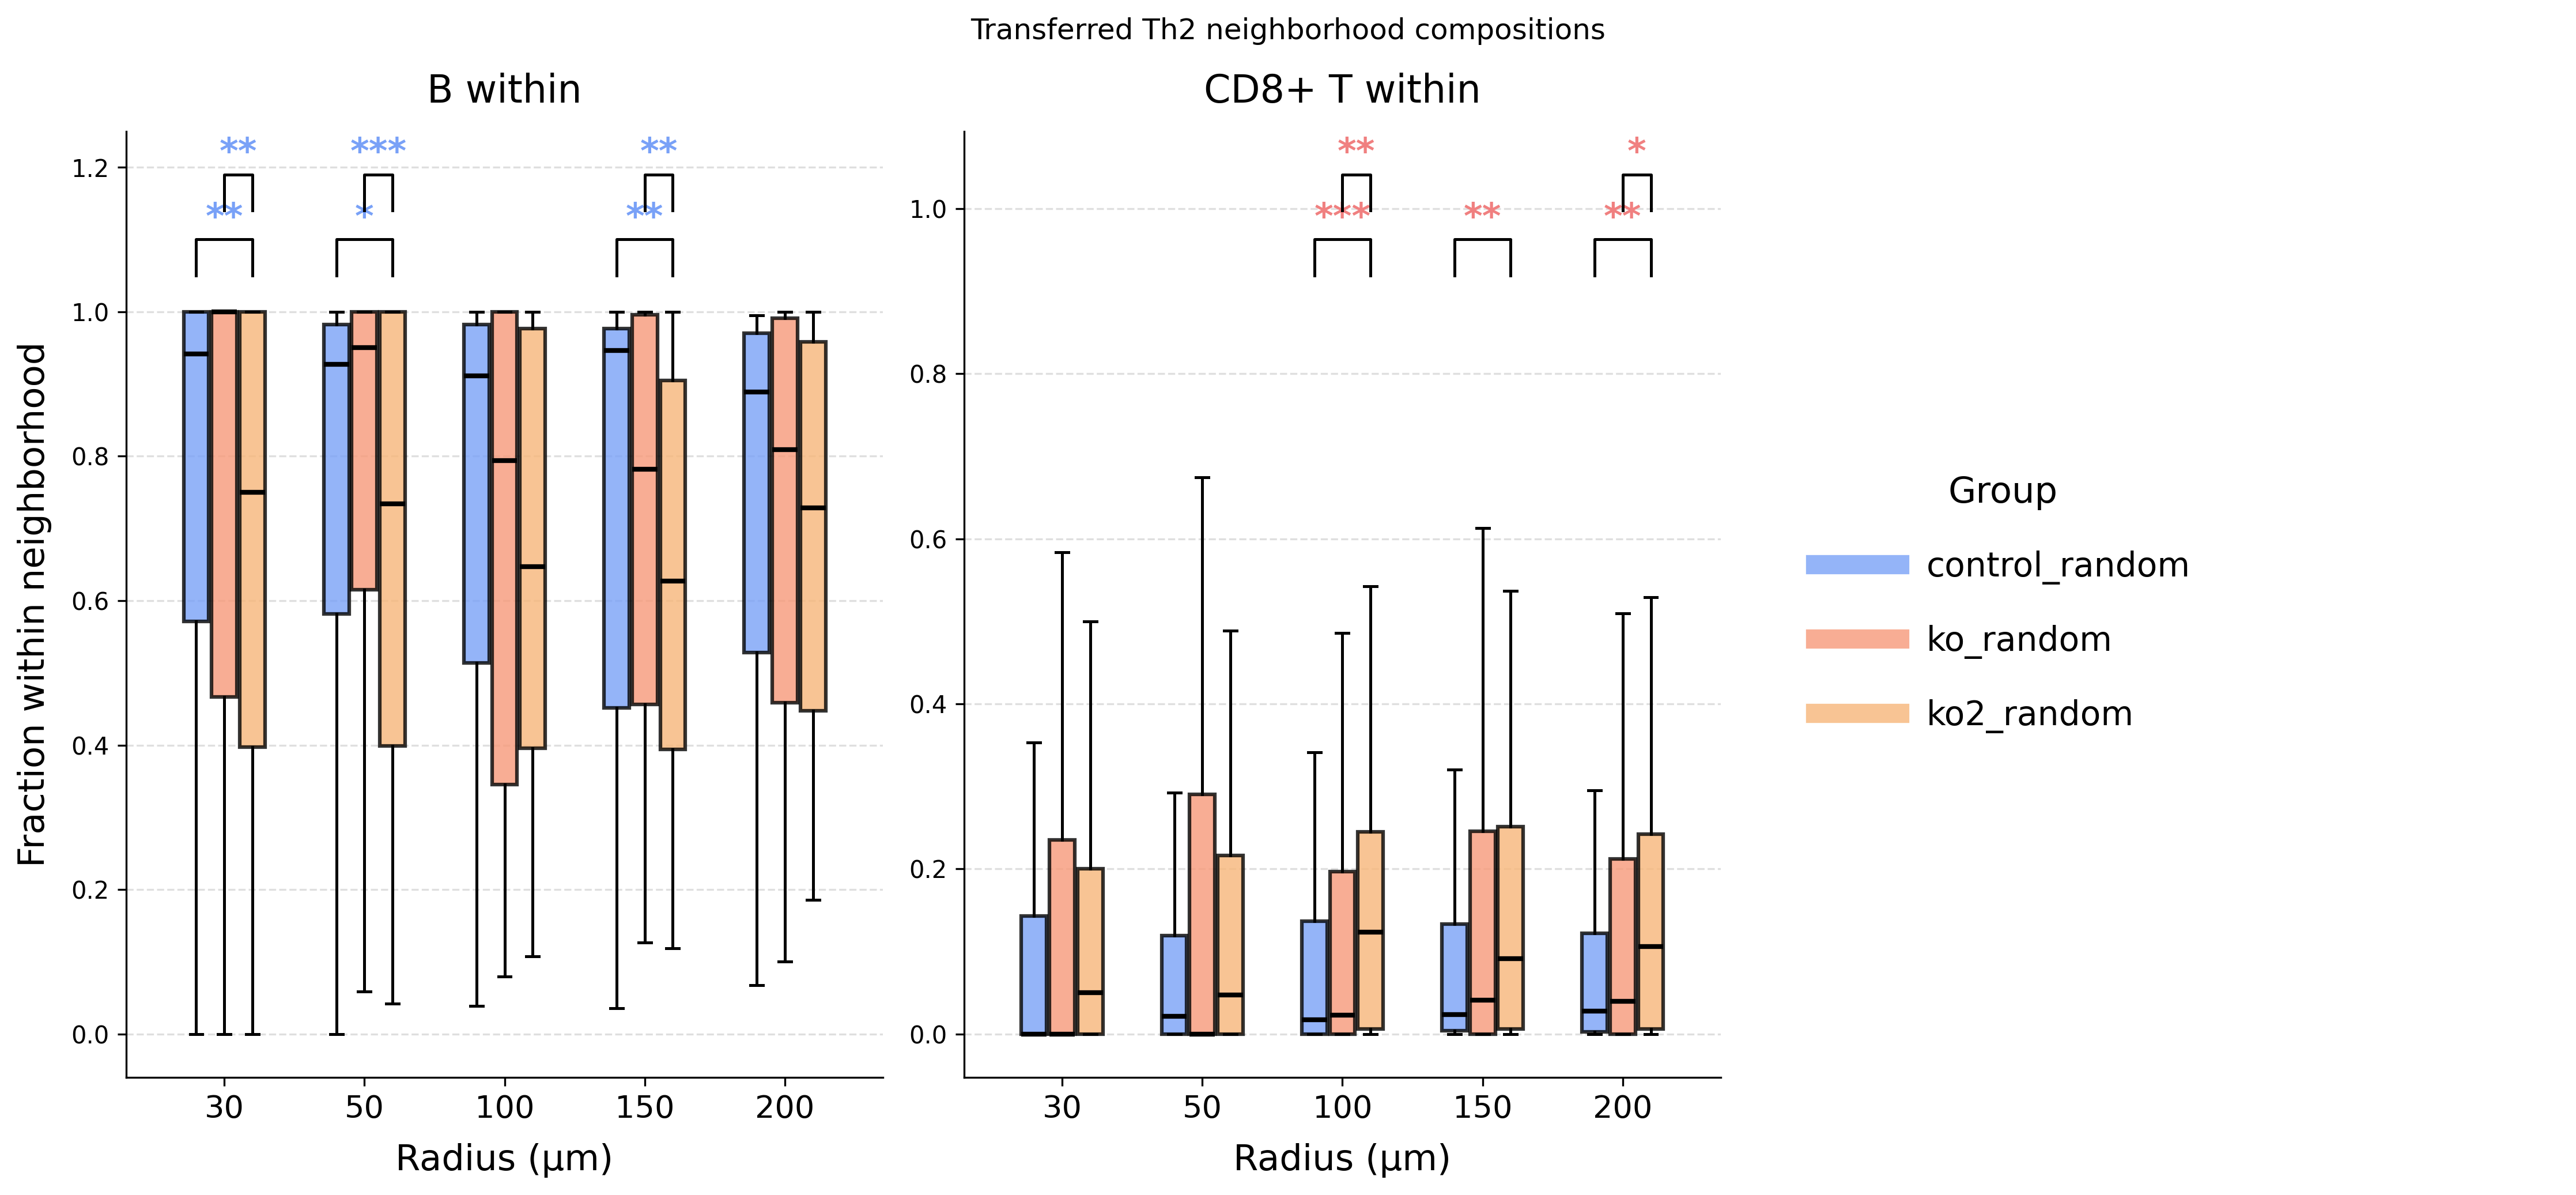

In [16]:
# Polyclonal Th2 

plot_neighborhood_boxplots(
    dicts=[b_dicts, cd8_dicts],
    dict_names=['B', 'CD8+ T'],
    groups=['control', 'ko', 'ko2'],
    radii=radii,
    ct_interest='Transferred Th2',
    save_path='./figures/visiumHD_polyth2_neighborhood_boxplots.svg'
)

plot_neighborhood_boxplots(
    dicts=[b_dicts, cd8_dicts],
    dict_names=['B', 'CD8+ T'],
    groups=['control_random', 'ko_random', 'ko2_random'],
    radii=radii,
    ct_interest='Transferred Th2'
)


### CCC

In [ ]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import commot as ct 

In [ ]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)

In [ ]:
adata = sc.read_h5ad('/ix3/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/commot/control_1.h5ad')
adata.obs['banksy_cluster'] = lymph1_banksy_df.loc[adata.obs_names, 'banksy_cluster']


In [ ]:
pathway = 'Ccl5-Ccr4'

ct.tl.communication_direction(adata, database_name='user_database', pathway_name=pathway, k=5)
ax = ct.pl.plot_cell_communication(adata, database_name='user_database', 
    # lr_pair=('Cxcl13','Cxcr5'), 
    lr_pair=(pathway.rsplit('-', 1)[0], pathway.rsplit('-', 1)[1]), 
    plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.6, summary='receiver', 
    background='summary', clustering='cell_type', cmap='Reds',
    normalize_v = True, normalize_v_quantile=0.995)
ax.set_title(pathway)

In [ ]:
pathway = 'Cxcl13-Cxcr5'

ct.tl.communication_direction(adata, database_name='user_database', pathway_name=pathway, k=5)
ax = ct.pl.plot_cell_communication(adata, database_name='user_database', 
    # lr_pair=('Cxcl13','Cxcr5'), 
    lr_pair=(pathway.rsplit('-', 1)[0], pathway.rsplit('-', 1)[1]), 
    plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.6, summary='receiver', 
    background='summary', clustering='cell_type', cmap='Reds',
    normalize_v = True, normalize_v_quantile=0.995)
ax.set_title(pathway)

In [ ]:
pathway = 'Ccl20-Ccr6'

ct.tl.communication_direction(adata, database_name='user_database', pathway_name=pathway, k=5)
ax = ct.pl.plot_cell_communication(adata, database_name='user_database', 
    # lr_pair=('Cxcl13','Cxcr5'), 
    lr_pair=(pathway.rsplit('-', 1)[0], pathway.rsplit('-', 1)[1]), 
    plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.6, summary='receiver', 
    background='summary', clustering='cell_type', cmap='Reds',
    normalize_v = True, normalize_v_quantile=0.995)
ax.set_title(pathway)

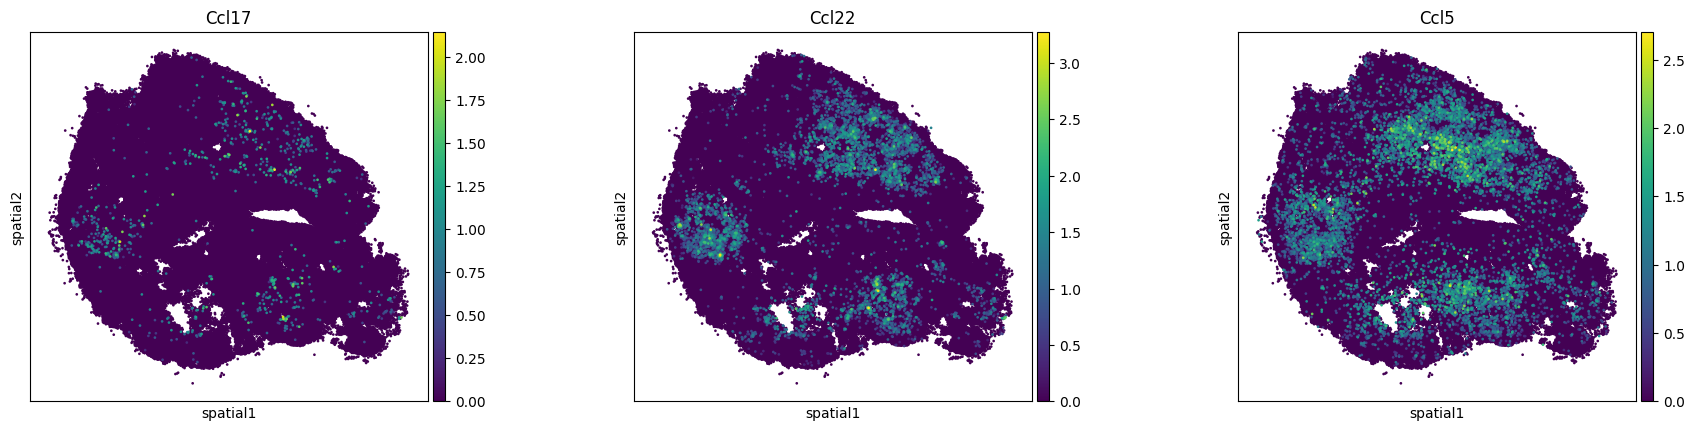

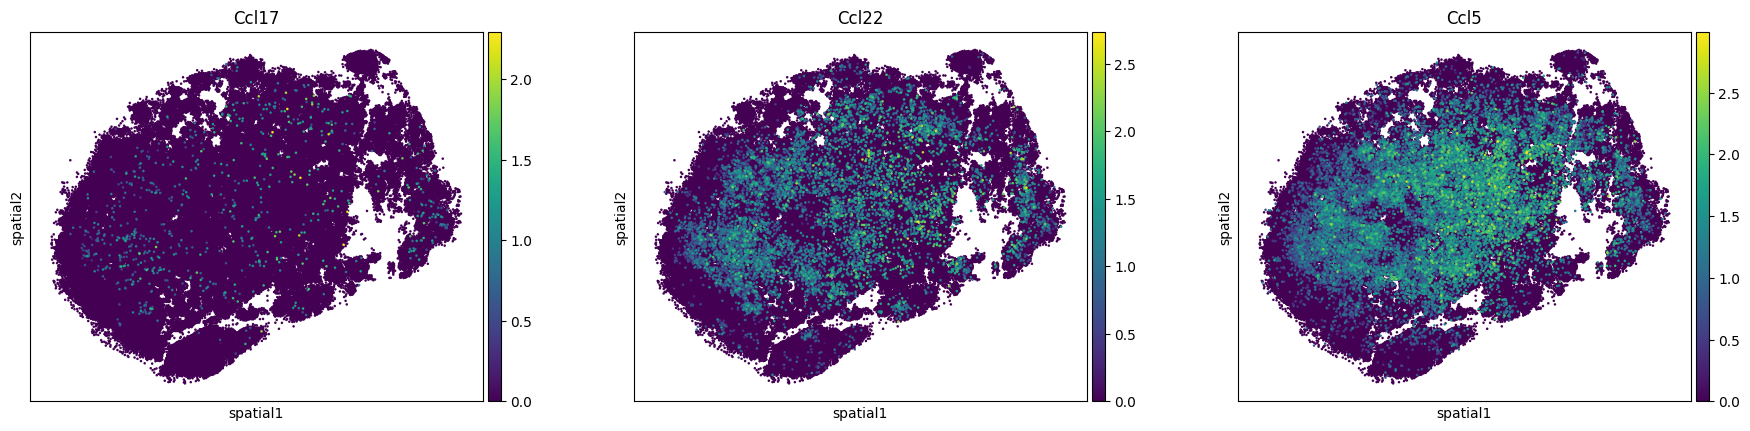

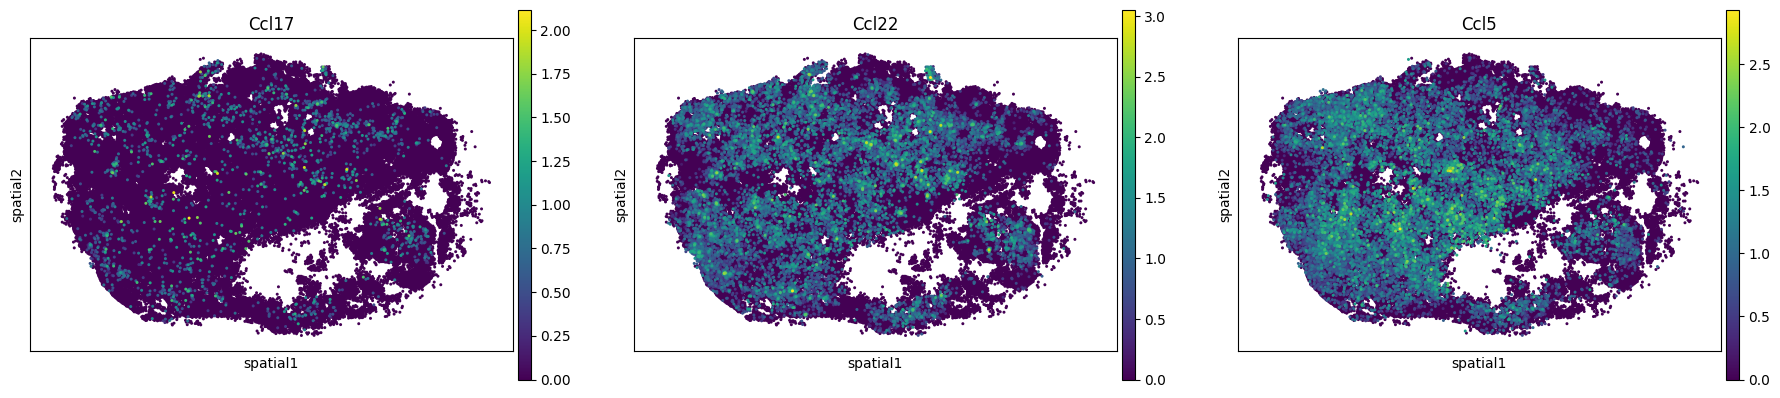

In [103]:
import scanpy as sc 

sc.pl.spatial(adata_control, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
sc.pl.spatial(adata_ko, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
sc.pl.spatial(adata_ko2, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)